In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 30)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
def visual_corr(df):
    # Select only numeric columns (ignoring 'product', 'posting_date', and other categorical columns)
    numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns

    # Calculate the correlation matrix
    correlation_matrix = df[numeric_cols].corr()

    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Mask to annotate values with absolute correlation > 0.6
    mask = np.abs(correlation_matrix) > 0.6
    annotations = correlation_matrix.where(mask).round(1).astype(str).replace('nan', '')

    # Plot a heatmap of the correlation matrixdef visual_corr(df):
    # Select only numeric columns (ignoring 'product', 'posting_date', and other categorical columns)
    numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns

    # Calculate the correlation matrix
    correlation_matrix = df[numeric_cols].corr()

    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Mask to annotate values with absolute correlation > 0.6 but < 1.0
    mask = (np.abs(correlation_matrix) > 0.6) & (np.abs(correlation_matrix) < 1.0)
    annotations = correlation_matrix.where(mask).round(1).astype(str).replace('nan', '')

    # Plot a heatmap of the correlation matrix
    plt.figure(figsize=(12, 12))
    sns.heatmap(
        correlation_matrix,
        annot=annotations, 
        cmap='coolwarm',
        fmt='', 
        linewidths=0.5,
        cbar=True
    )
    plt.title("Correlation Matrix")

## Define Cross validation Pipeline

In [4]:
def train_evaluate_model(df, regressor, target_col='price_per_kg', n_splits=4):
    """
    Train and evaluate a time series model with n-fold cross-validation.
    
    Args:
        df (pd.DataFrame): DataFrame with `year_week` as index and the features.
        target_col (str): The name of the target column.
        n_splits (int): Number of splits for TimeSeriesSplit.

    Returns:
        pd.DataFrame: DataFrame containing evaluation metrics for each fold.
    """

    # Ensure the DataFrame is sorted by index
    df = df.sort_index()
    
    # Preprocess the dataset
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Identify categorical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    # Identify numeric columns
    numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()
    
    if isinstance(regressor, CatBoostRegressor):
        # Skip preprocessing for CatBoost (it handles categorical variables on its own)
        X_preprocessed = X
    else:
        # For other regressors, apply OneHotEncoder for categorical columns and StandardScaler for numeric columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
                ('num', StandardScaler(), numeric_cols)
            ], 
            remainder='passthrough'  # Keep other columns unchanged
        )

        X_preprocessed = preprocessor.fit_transform(X)

    # Dynamically adjust test size
    test_size = int(len(df) * 0.2)
    min_samples_per_split = test_size + (len(df) // n_splits)

    if len(df) < min_samples_per_split:
        raise ValueError(f"Not enough data for {n_splits} splits with a test size of {test_size}. "
                         f"Consider reducing n_splits or increasing the dataset size.")

    # Initialize TimeSeriesSplit
    tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=0)

    # Placeholder for metrics
    metrics = []
    fold = 0

    # # Plot Train/Test Splits
    # fig, axs = plt.subplots(n_splits, 1, figsize=(15, 15), sharex=True)

    # for train_idx, val_idx in tss.split(X_preprocessed):
    #     # Split preprocessed data
    #     X_train_preprocessed = X_preprocessed[train_idx]
    #     y_train = y.iloc[train_idx]
    #     X_val_preprocessed = X_preprocessed[val_idx]
    #     y_val = y.iloc[val_idx]

    #     # Plot train/test split
    #     y.iloc[train_idx].plot(ax=axs[fold],
    #                            label='Training Set',
    #                            title=f'Data Train/Test Split Fold {fold}')
    #     y.iloc[val_idx].plot(ax=axs[fold],
    #                           label='Validation Set')
    #     axs[fold].axvline(y.index[val_idx].min(), color='black', ls='--')
    #     axs[fold].legend()
    #     fold += 1

    # Reset fold counter for metrics calculation
    fold = 0
    for train_idx, val_idx in tss.split(X_preprocessed):
        model = regressor
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        # Initialize the model based on the regressor
        if isinstance(regressor, CatBoostRegressor):
            X_train_preprocessed = X_preprocessed.iloc[train_idx]
            X_val_preprocessed = X_preprocessed.iloc[val_idx]
            # Fit with categorical features and eval_set
            model.fit(
                X_train_preprocessed, 
                y_train, 
                cat_features=categorical_cols,
                eval_set=[(X_val_preprocessed, y_val)], 
                verbose=False
            )
        elif isinstance(regressor, RandomForestRegressor):
            # Split preprocessed data
            X_train_preprocessed = X_preprocessed[train_idx]
            X_val_preprocessed = X_preprocessed[val_idx]
            model.fit(X_train_preprocessed, y_train)
        else:
            # For other models like XGBoost
            # Split preprocessed data
            X_train_preprocessed = X_preprocessed[train_idx]
            X_val_preprocessed = X_preprocessed[val_idx]
            model.fit(X_train_preprocessed, y_train, eval_set=[(X_val_preprocessed, y_val)], verbose=False)

        # Predict and calculate metrics
        y_pred = model.predict(X_val_preprocessed)
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, y_pred)

        # Store metrics
        metrics.append({'fold': fold, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2})
        fold += 1

    # Summarize Metrics
    metrics_df = pd.DataFrame(metrics)
    print(metrics_df)

    # Average metrics over folds
    avg_metrics = metrics_df.drop('fold', axis=1).mean()
    print(f"Average Metrics: \n{avg_metrics}")

    return metrics_df


## Weekly Model

In [11]:
dfw = pd.read_csv('../../features/weekly_feat.csv').drop(columns=['year', 'week'])
dfw = dfw[dfw['price_per_kg'] <= 5]
dfw['posting_date'] = pd.to_datetime(dfw['posting_date'])
dfw.set_index('posting_date', inplace=True)

#### RandomForest Regressor

   fold       MAE       MSE      RMSE        R2
0     0  0.083834  0.018465  0.135887  0.385812
1     1  0.115020  0.042009  0.204962  0.508994
2     2  0.090028  0.017261  0.131380  0.702316
3     3  0.108282  0.028299  0.168224  0.417007
Average Metrics: 
MAE     0.099291
MSE     0.026509
RMSE    0.160113
R2      0.503532
dtype: float64


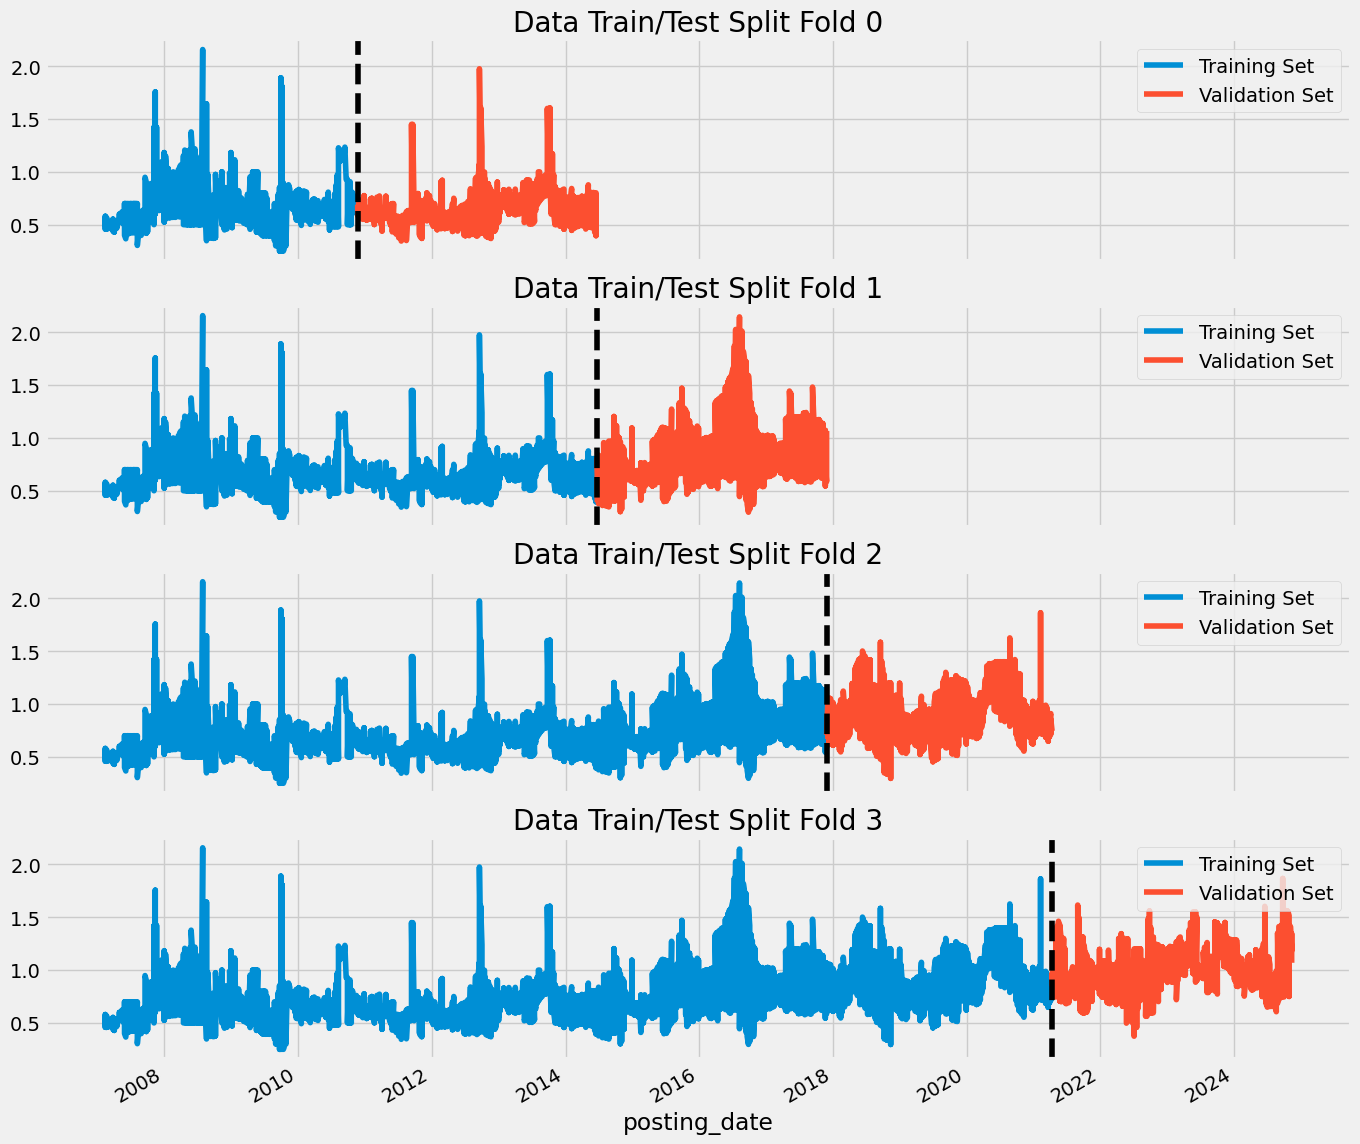

In [ ]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor()
res = train_evaluate_model(dfw, rf_regressor)

#### XGBoost Regressor

In [ ]:
# XGBoost Regressor
xgb_regressor = XGBRegressor()
res = train_evaluate_model(dfw, xgb_regressor)

   fold       MAE       MSE      RMSE        R2
0     0  0.071755  0.014680  0.121161  0.511714
1     1  0.085729  0.022999  0.151653  0.731193
2     2  0.091972  0.017923  0.133878  0.690889
3     3  0.083376  0.017492  0.132256  0.639656
Average Metrics: 
MAE     0.083208
MSE     0.018273
RMSE    0.134737
R2      0.643363
dtype: float64


#### CatBoost Regressor

In [44]:
# CatBoostRegressor
cgb_regressor = CatBoostRegressor(n_estimators=100, random_seed=42, verbose=0)
res = train_evaluate_model(dfw, cgb_regressor)

   fold       MAE       MSE      RMSE        R2
0     0  0.065519  0.011739  0.108348  0.609530
1     1  0.099397  0.029413  0.171502  0.656220
2     2  0.078055  0.013822  0.117567  0.761621
3     3  0.086940  0.017424  0.132002  0.641039
Average Metrics: 
MAE     0.082478
MSE     0.018100
RMSE    0.132355
R2      0.667103
dtype: float64


### Monthly Model

In [ ]:
dfm = pd.read_csv('../../features/monthly_feat.csv').drop(columns=['year', 'week'])
# There was one really high value of price that is above 5, so drop it
dfm = dfm[dfm['price_per_kg'] <= 5]
dfm['posting_date'] = pd.to_datetime(dfm['posting_date'])
dfm.set_index('posting_date', inplace=True)

In [8]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor()
res = train_evaluate_model(dfm, rf_regressor)

   fold       MAE       MSE      RMSE        R2
0     0  0.103953  0.022763  0.150873  0.358370
1     1  0.135918  0.048595  0.220444  0.407544
2     2  0.156465  0.042721  0.206691  0.272343
3     3  0.148678  0.040853  0.202121  0.161241
Average Metrics: 
MAE     0.136254
MSE     0.038733
RMSE    0.195032
R2      0.299875
dtype: float64


In [ ]:
# XGBoost Regressor
xgb_regressor = XGBRegressor()
res = train_evaluate_model(dfm, xgb_regressor)

   fold       MAE       MSE      RMSE        R2
0     0  0.096209  0.017910  0.133827  0.495166
1     1  0.116462  0.034634  0.186101  0.577761
2     2  0.158946  0.045400  0.213072  0.226717
3     3  0.145131  0.039960  0.199901  0.179568
Average Metrics: 
MAE     0.129187
MSE     0.034476
RMSE    0.183225
R2      0.369803
dtype: float64


In [7]:
cgb_regressor = CatBoostRegressor(n_estimators=1000, random_seed=42, verbose=0)
res = train_evaluate_model(dfm, cgb_regressor)

   fold       MAE       MSE      RMSE        R2
0     0  0.094153  0.017172  0.131044  0.515944
1     1  0.124402  0.040983  0.202443  0.500351
2     2  0.116653  0.024732  0.157265  0.578741
3     3  0.144214  0.038815  0.197016  0.203077
Average Metrics: 
MAE     0.119856
MSE     0.030426
RMSE    0.171942
R2      0.449528
dtype: float64
